**Задание**
1. Выберите ряд из первого задания.
2. Постройте его модель GARCH.
3. Оформите отчёт в Jupyter-ноутбук.

**Пункт 1 задания**

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Возьмем для анализа следующий временной ряд
dowjones_closing = pd.read_csv("/content/weekly-closings-of-the-dowjones-.csv")

In [3]:
all_series = {"Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"]}

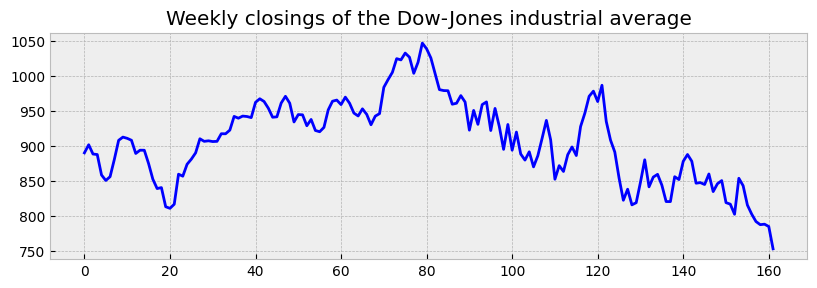

In [4]:
#Отобразим выбранный ВР

with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

In [5]:
'''
Функция для использования теста Дики-Фуллера
для проверки временного ряда на стационарность
'''

def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

Построим график автокорреляции, частичной автокорреляции
для визуального анализа наличия/отсутствия элементов временного ряда (тренд/сезонность/размах/шум)

In [6]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


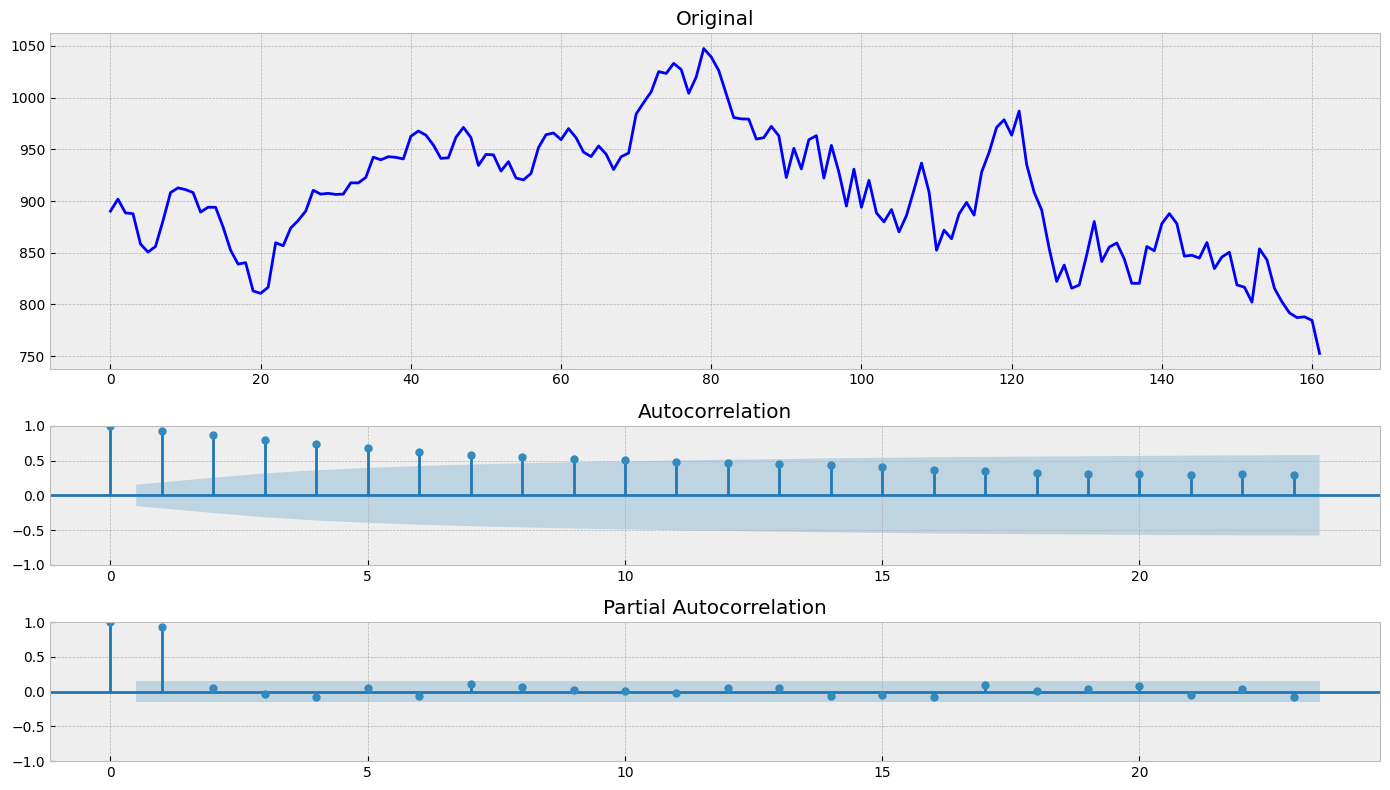

In [7]:
tsplot(dowjones_closing['Close'])

Визуально временной ряд "Weekly closings of the Dow-Jones industrial average" не стационарен, поскольку:
- График не похож на шум
- Заметна трендовая составляющая на отдельных участках
- График поход на Random Walk
- Непостоянная дисперсия

Значение p-value > 0,05 (по тесту Дики-Фуллера). Значит, временной ряд не стационарен, значения в нем зависят от времени.

**Пункт 2. Построение модели GARCH**

Для построения модели GARCH выбранный ВР необходимо привести к стационарному виду.

**2.1. Приводим ВР к стационарному виду**

**Нормализуем дисперсию**

In [8]:
dowjones_closing_stat, best_lambda = boxcox(dowjones_closing['Close'])

In [9]:
print(f'Оптимальная лямбда - {best_lambda:.4f}')

Оптимальная лямбда - 1.1328


Results of Dickey-Fuller Test:
Test Statistic                  -1.327773
p-value                          0.616372
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


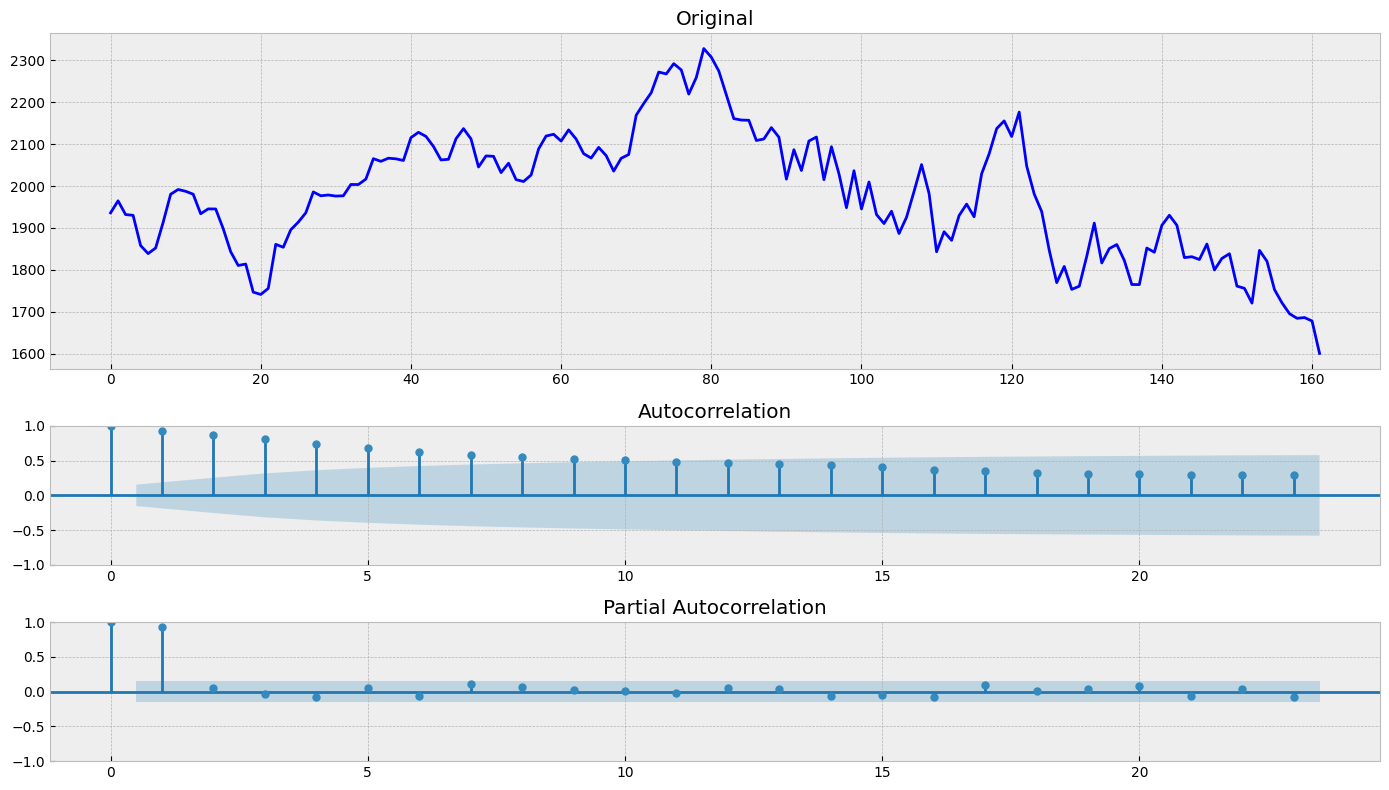

In [10]:
tsplot(dowjones_closing_stat)

Нормализация дисперсия не привела к видимым результатам. По коррелограмме заметен тренд.

**Убираем тренд**

In [11]:
dowjones_closing_stat = np.diff(dowjones_closing_stat, 1)

Results of Dickey-Fuller Test:
Test Statistic                -1.302750e+01
p-value                        2.382691e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


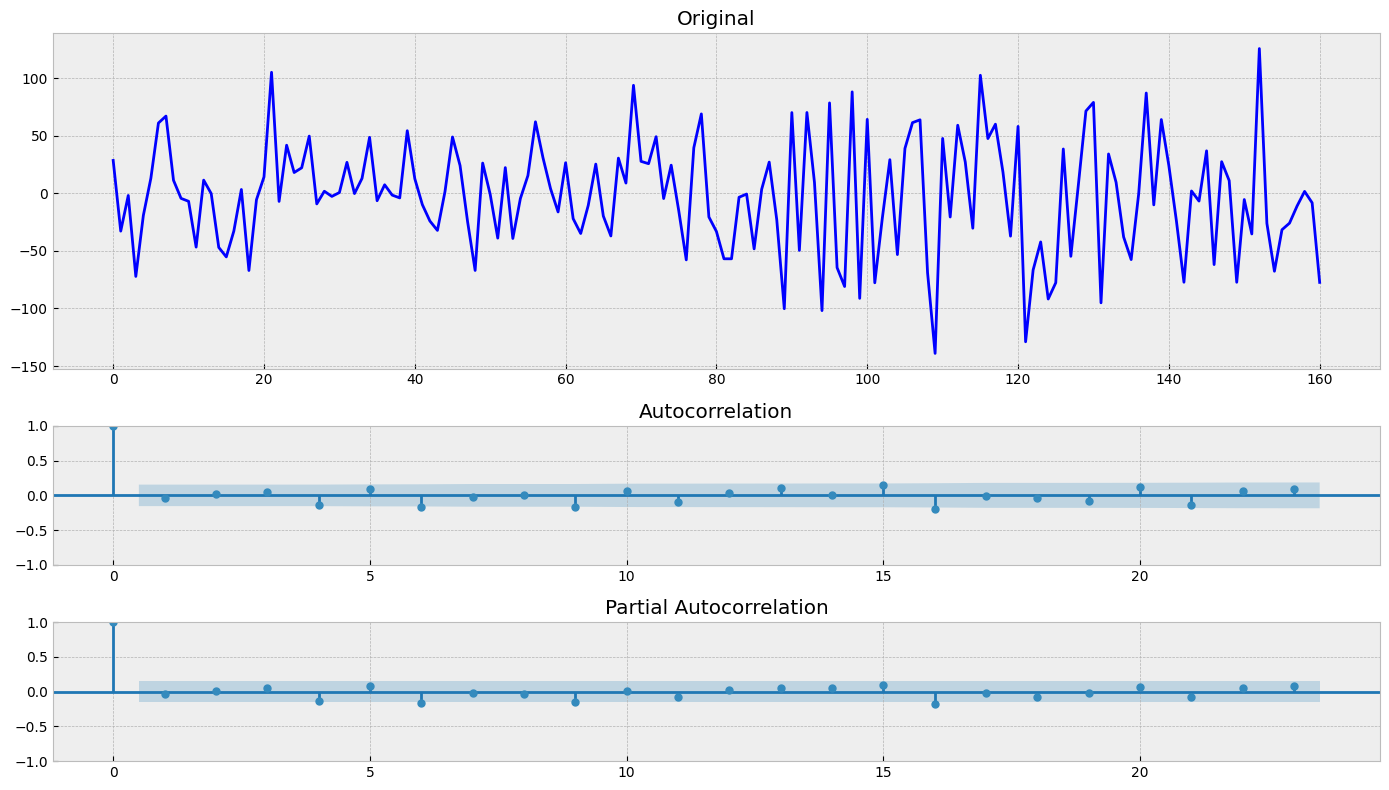

In [12]:
tsplot(dowjones_closing_stat)

Значение p-value < 0,05.
Тест Дики-Фуллера и графики коррелограмм отвергают гипотезу о нестационарности ряда.
Исследуемый временной ряд приведен к стационарному виду.

**2.2. Применяем модель GARCH к ВР**

In [13]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 10.5 MB/s eta 0:00:00


In [14]:
from arch import arch_model
import statsmodels.tsa.arima.model as smta

In [15]:
# Т.к. GARCH – это ARMA-процесс для дисперсии ВР, то
# для нахождения параметров модели, можем использовать подход, как для модели ARIMA

def _get_best_model(TS):
    best_aic = np.inf
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    # Указываем тренд при создании модели
                    tmp_mdl = smta.ARIMA(TS, order=(i, d, j)).fit()
                    tmp_aic = tmp_mdl.aic

                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except Exception as e:
                    #print(f'Error for order {(i, d, j)}: {e}')
                    continue
    print('Best model: aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order, best_mdl

In [16]:
best_aic, best_order, best_mdl = _get_best_model(dowjones_closing_stat)

Best model: aic: 1705.23396 | order: (2, 1, 3)


In [17]:
print(best_aic)
print(best_order)
print(best_mdl)

1705.2339628616317
(2, 1, 3)


In [27]:
print(best_mdl.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  161
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -846.617
Date:                Fri, 09 Aug 2024   AIC                           1705.234
Time:                        13:49:46   BIC                           1723.685
Sample:                             0   HQIC                          1712.726
                                - 161                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5984      0.060    -26.558      0.000      -1.716      -1.480
ar.L2         -0.9286      0.052    -17.806      0.000      -1.031      -0.826
ma.L1          0.5761      0.654      0.880      0.3

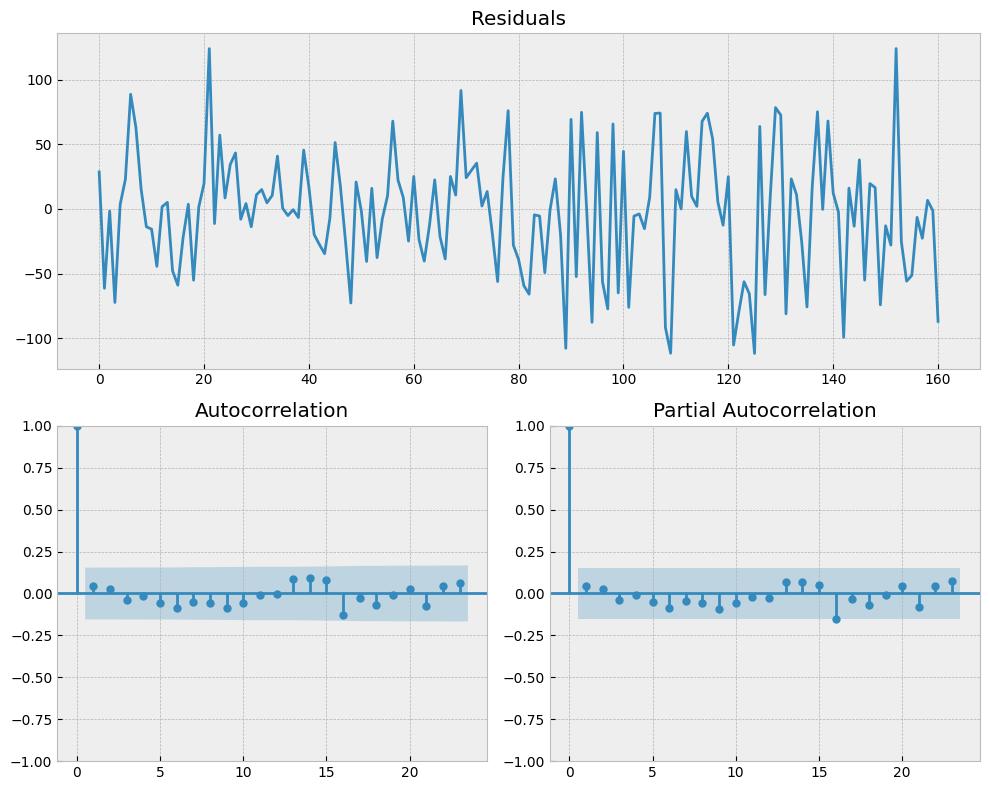

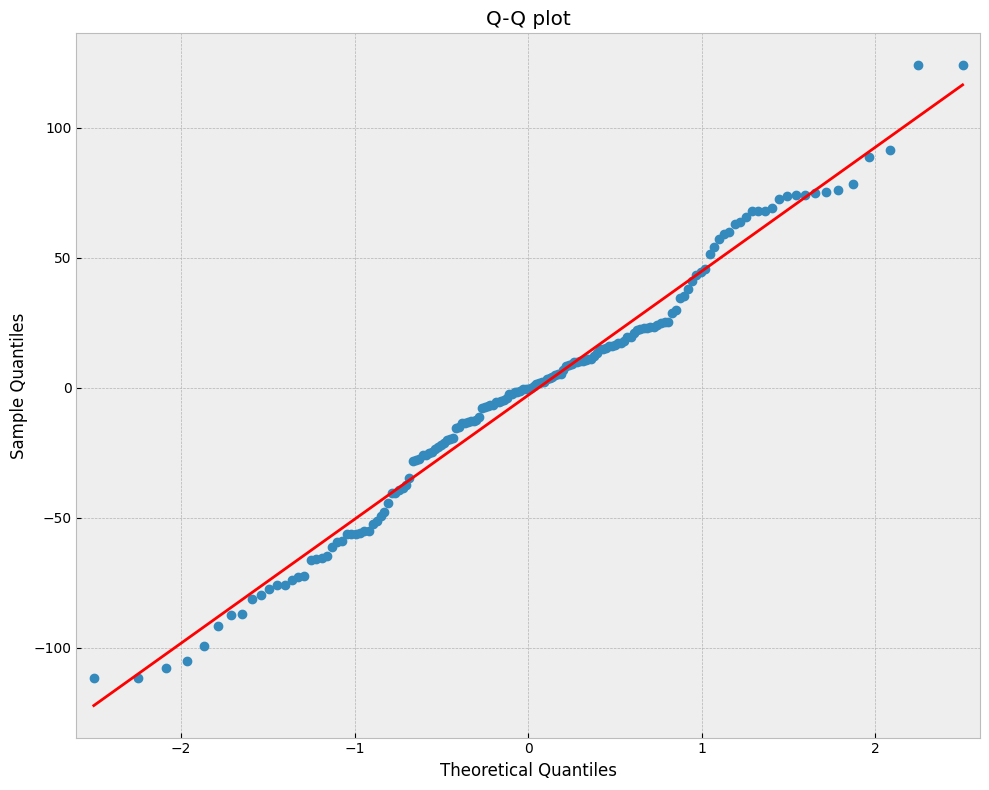

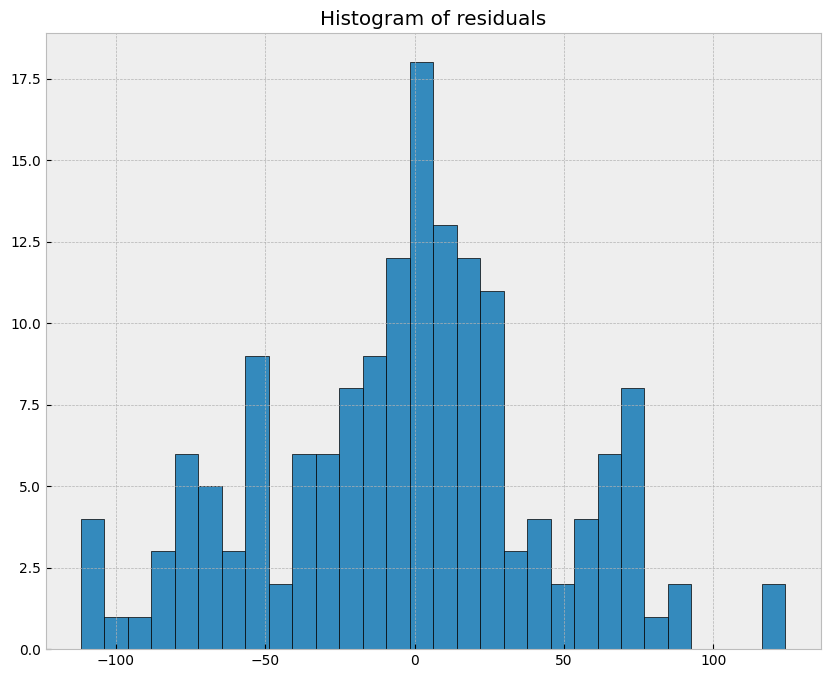

In [18]:
# Функция для построения графиков остатков модели
def tsplot1(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, (pd.Series, np.ndarray)):
        y = np.array(y)

    plt.style.use(style)
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    ts_ax.plot(y)
    ts_ax.set_title('Residuals')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(10, 8))
    qq_ax = fig.add_subplot(111)
    sm.qqplot(y, line='s', ax=qq_ax)
    qq_ax.set_title('Q-Q plot')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 8))
    plt.hist(y, bins=30, edgecolor='k')
    plt.title('Histogram of residuals')
    plt.show()

# Визуализация остатков модели
tsplot1(best_mdl.resid)

In [19]:
# Применение модели GARCH к ВР
p_ = best_order[0]
o_ = best_order[1]
q_ = best_order[2]

# Использование распределения Стьюдента для улучшения подгонки
am = arch_model(dowjones_closing_stat, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -847.781
Distribution:      Standardized Student's t   AIC:                           1705.56
Method:                  Maximum Likelihood   BIC:                           1720.97
                                              No. Observations:                  161
Date:                      Fri, Aug 09 2024   Df Residuals:                      160
Time:                              13:38:56   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0

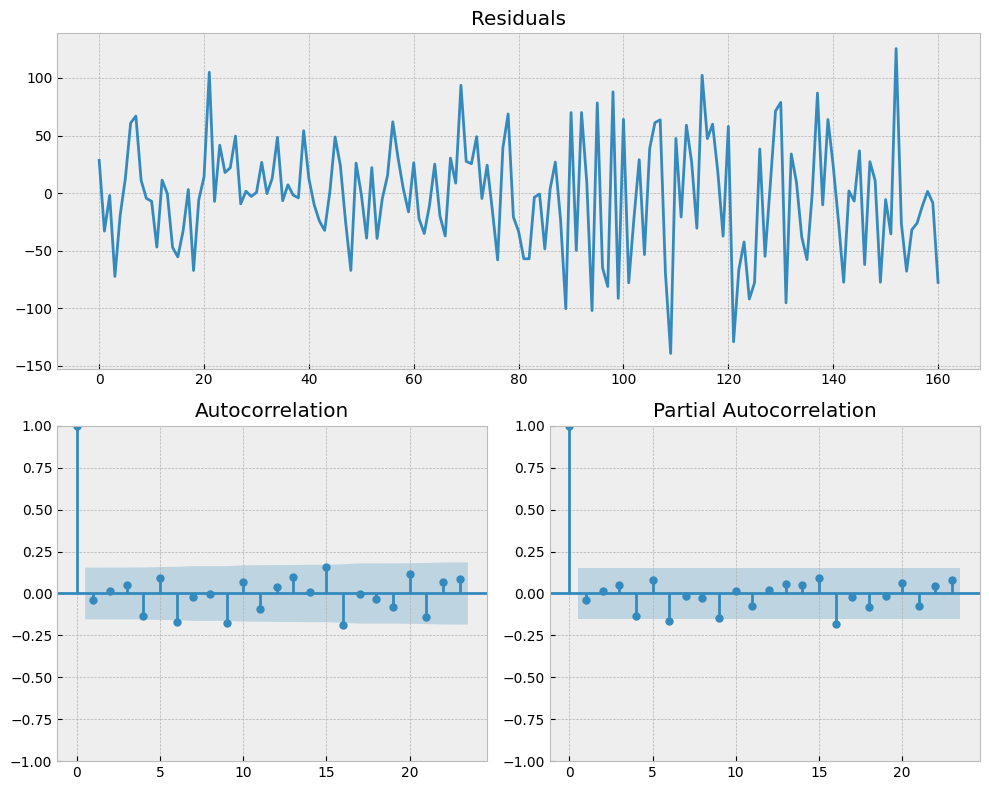

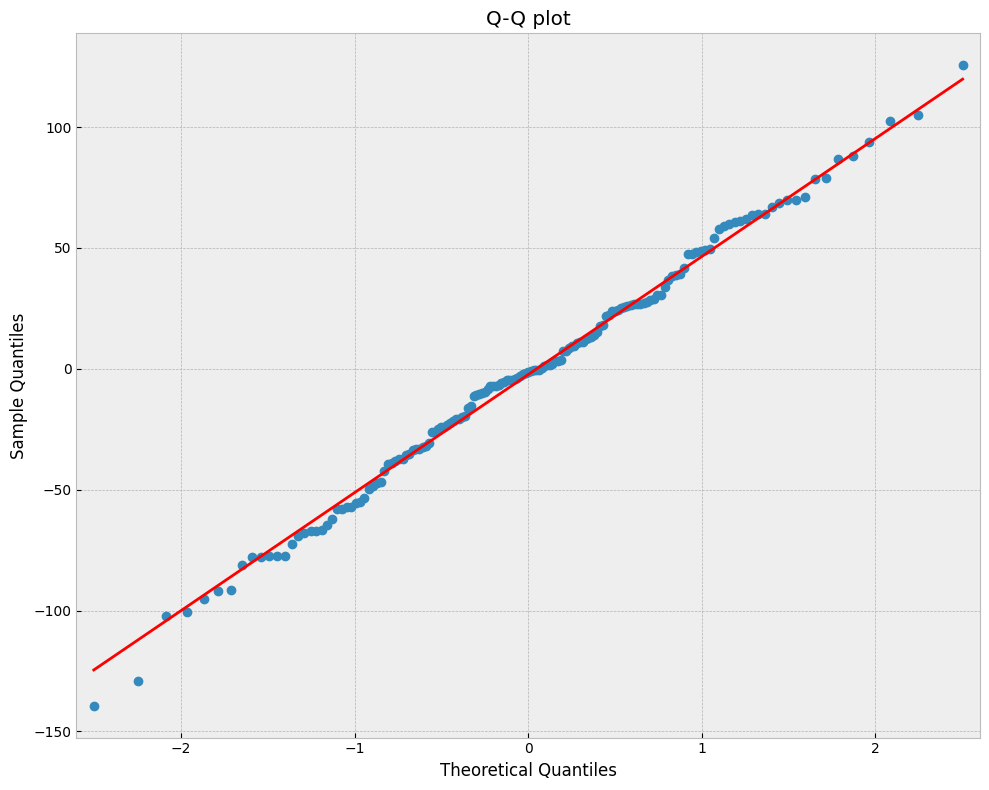

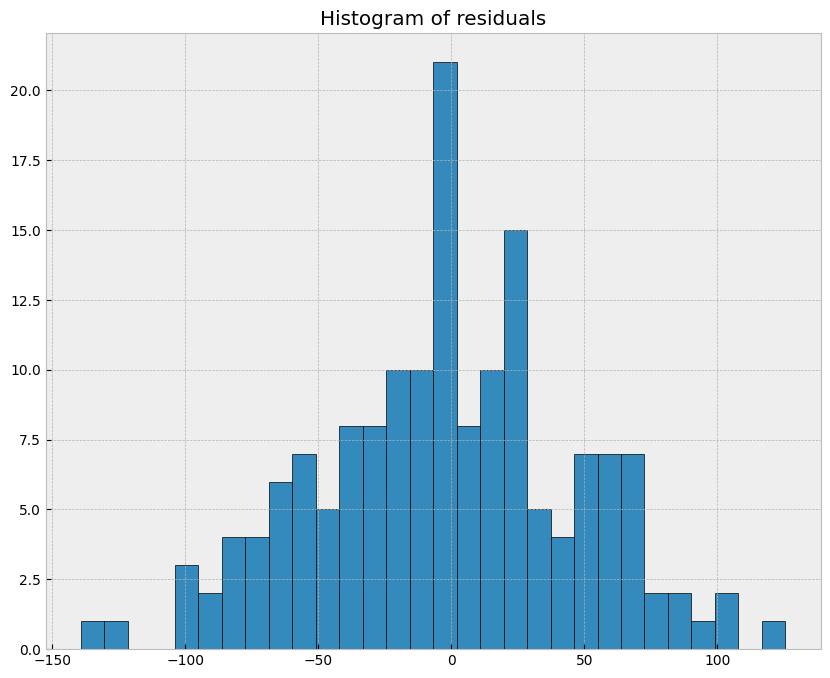

In [25]:
# Визуализация остатков модели GARCH
tsplot1(res.resid)